# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


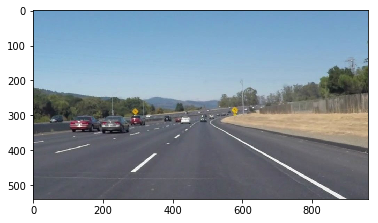

In [212]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

Below are other helper functions used for lines interpolation.

In [9]:
# Global variables storing previous frame info
prev_left_fitted_lines = []
prev_right_fitted_lines = []
prev_left_weights = []
prev_right_weights = []

def reset_frames():
    global prev_left_fitted_lines
    global prev_right_fitted_lines
    global prev_left_weights
    global prev_right_weights
    prev_left_fitted_lines = []
    prev_right_fitted_lines = []
    prev_left_weights = []
    prev_right_weights = []
    
def inverse_fit(fit, y):
    # Given a line fit and a y-value, return its x value
    return int((y-fit[1])/fit[0])

def fit_line(x_arr, y_arr, side=0):
    """
    Fit a line onto img with array of (x,y) points.
    Need to specify the min and max y to determine the segment.
    Return the fitted line.
    """
    if not x_arr:
        return prev_left_fitted_lines[-1] if side == 0 else prev_right_fitted_lines[-1]

    return np.polyfit(x_arr, y_arr, 1)

def smooth_line(line, weight, num_prev_frames=5, discount=.7, side=0):
    """
    Use previous frames to smooth out the slope and intercept of the current frame
    """
    global prev_left_fitted_lines
    global prev_right_fitted_lines
    global prev_left_weights
    global prev_right_weights
    
    weight_discounts = np.flipud(np.cumprod([1] + [discount]*num_prev_frames)) # [..., discount**2, discount, 1]
    
    if side == 0:
        line_list = prev_left_fitted_lines + [line]
        weight_list = np.multiply(prev_left_weights + [weight], weight_discounts[-len(prev_left_weights)-1:])
    else:
        line_list = prev_right_fitted_lines + [line]
        weight_list = np.multiply(prev_right_weights + [weight], weight_discounts[-len(prev_right_weights)-1:])

    slope = np.average([m[0] for m in line_list], weights=weight_list)
    intercept = np.average([m[1] for m in line_list], weights=weight_list)
    new_line = np.array([slope, intercept])

    if side == 0:
        prev_left_fitted_lines.append(new_line)
        prev_left_weights.append(weight)
        if len(prev_left_fitted_lines) > num_prev_frames:
            prev_left_fitted_lines.pop(0)
            prev_left_weights.pop(0)
    else:
        prev_right_fitted_lines.append(new_line)
        prev_right_weights.append(weight)
        if len(prev_right_fitted_lines) > num_prev_frames:
            prev_right_fitted_lines.pop(0)
            prev_right_weights.pop(0)
            
    return new_line

def draw_rectangle(img, left_line, right_line, min_y, max_y, color=(0,255,0)):
    # Draw rectangle bounded by lanes
    vertices = np.array([[(inverse_fit(left_line,max_y),max_y),(inverse_fit(left_line,min_y),min_y),\
                          (inverse_fit(right_line,min_y),min_y),(inverse_fit(right_line,max_y),max_y)]])
    cv2.fillPoly(img, vertices, color)
    
def draw_interpolated_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    Interpolate lines and return the left and right lane lines, as well as the vanquish point for the lines
    """
    # Separate left and right lane lines by positive and negative slopes.
    # Bin the polar coordinates and find the bin that has the longest accumulate length.
    # We use polar coordinates here to mimic the implementation of Hough Transform.
    # The reason for binning is to find the most common line group and ignore noise.
    min_rho, max_rho = (0, np.sqrt(img.shape[0]**2+img.shape[1]**2))
    min_phi, max_phi = (-np.pi*3/8, np.pi*3/8) # ignore lines that are too flat or too steep
    n_rho, n_phi = (80, 8) # number of bins
    step_rho = (max_rho-min_rho) / n_rho
    step_phi = (max_phi-min_phi) / n_phi
    left_bins = np.zeros((n_rho, n_phi))
    right_bins = np.zeros((n_rho, n_phi))
    left_lines_in_bins = [[[]]*n_phi]*n_rho # store lines that fall in left bins
    right_lines_in_bins = [[[]]*n_phi]*n_rho # store lines that fall in right bins
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            line_len = np.sqrt((x1-x2)**2 + (y1-y2)**2)
            rho = abs(x1*y2-x2*y1) / line_len
            phi = np.pi/2 if y1 == y2 else np.arctan((x2-x1)/(y1-y2))
            rho_ind = math.floor((rho-min_rho) / step_rho)
            phi_ind = math.floor((phi-min_phi) / step_phi)
            if phi > np.pi/8 and phi < max_phi and x1 < img.shape[1]/2:
                left_lines_in_bins[rho_ind][phi_ind].append([x1, y1, x2, y2])
                left_bins[rho_ind, phi_ind] += line_len
            if phi < -np.pi/8 and phi > min_phi and x1 > img.shape[1]/2:
                right_lines_in_bins[rho_ind][phi_ind].append([x1, y1, x2, y2])
                right_bins[rho_ind, phi_ind] += line_len

    # Find the bin that has longest accumulate length
    left_rho_ind, left_phi_ind = np.unravel_index(left_bins.argmax(), left_bins.shape)
    right_rho_ind, right_phi_ind = np.unravel_index(right_bins.argmax(), right_bins.shape)

    # For lines in the maximal bin, fit the best line through their endpoints
    left_line_group = left_lines_in_bins[left_rho_ind][left_phi_ind]
    right_line_group = right_lines_in_bins[right_rho_ind][right_phi_ind]
    left_lane_x = [l[0] for l in left_line_group] + [l[2] for l in left_line_group]
    left_lane_y = [l[1] for l in left_line_group] + [l[3] for l in left_line_group]
    right_lane_x = [l[0] for l in right_line_group] + [l[2] for l in right_line_group]
    right_lane_y = [l[1] for l in right_line_group] + [l[3] for l in right_line_group]
    
    left_line = fit_line(left_lane_x, left_lane_y, side=0)
    right_line = fit_line(right_lane_x, right_lane_y, side=1)
    
    # Smooth out slopes and intercepts from previous frames
    if left_bins.max() > 0:
        left_line = smooth_line(left_line, left_bins.max(), side=0)
    if right_bins.max() > 0:
        right_line = smooth_line(right_line, right_bins.max(), side=1)
    
    # Draw lines
    vanquish_y = min(min(left_lane_y, default=img.shape[0]), min(right_lane_y, default=img.shape[0]))
    cv2.line(img, (inverse_fit(left_line, vanquish_y), vanquish_y), (inverse_fit(left_line, img.shape[0]), img.shape[0]), color, thickness)
    cv2.line(img, (inverse_fit(right_line, vanquish_y), vanquish_y), (inverse_fit(right_line, img.shape[0]), img.shape[0]), color, thickness)
    
    return left_line, right_line, vanquish_y

def hough_interpolated_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    # Draw lines
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    left_line, right_line, vanquish_y = draw_interpolated_lines(line_img, lines)
    
    # Draw rectangle
    rect_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_rectangle(rect_img, left_line, right_line, vanquish_y, img.shape[0])
    
    return weighted_img(rect_img, line_img, 1., 0.4, 0.)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [3]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteCurve_out.png',
 'solidWhiteRight.jpg',
 'solidWhiteRight_out.png',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowCurve2_out.png',
 'solidYellowCurve_out.png',
 'solidYellowLeft.jpg',
 'solidYellowLeft_out.png',
 'whiteCarLaneSwitch.jpg',
 'whiteCarLaneSwitch_out.png']

run your solution on all test_images and make copies into the test_images directory).

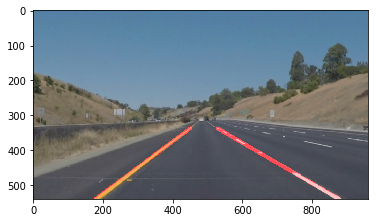

In [4]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

import os

test_dir = 'test_images'
output_suffix_ext = '_out.png'

for file in os.listdir(test_dir):
    if file.endswith(output_suffix_ext):
        continue

    reset_frames()

    # Grayscale the image.
    image = mpimg.imread(os.path.join(test_dir, file))
    gray = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing.
    # Canny function already applies smoothing, but this step is so we can add more smoothing!
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define params for Canny and apply
    low_threshold = 30
    high_threshold = 80
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Region of interests
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(imshape[1]*7/16, imshape[0]*5/8), (imshape[1]*9/16, imshape[0]*5/8), (imshape[1],imshape[0])]], dtype=np.int32)
    edges_roi = region_of_interest(edges, vertices)

    # Define Hough params and apply
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_len = 20
    max_line_gap = 20
    line_image = hough_interpolated_lines(edges_roi, rho, theta, threshold, min_line_len, max_line_gap)

    # Combine lines and original image
    result_image = weighted_img(line_image, image, 0.8, 1., 0.)
    plt.imshow(result_image)
    
    # Save image
    output_filename = os.path.splitext(file)[0] + output_suffix_ext
    plt.savefig(os.path.join(test_dir, output_filename))


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    # Grayscale the image.
    gray = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing.
    # Canny function already applies smoothing, but this step is so we can add more smoothing!
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define params for Canny and apply
    low_threshold = 40
    high_threshold = 100
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Region of interests
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(imshape[1]*7/16, imshape[0]*5/8), (imshape[1]*9/16, imshape[0]*5/8), (imshape[1],imshape[0])]], dtype=np.int32)
    edges_roi = region_of_interest(edges, vertices)

    # Define Hough params and apply
    rho = 2
    theta = np.pi/180
    threshold = 20
    min_line_len = 20
    max_line_gap = 10
    line_image = hough_interpolated_lines(edges_roi, rho, theta, threshold, min_line_len, max_line_gap)

    # Combine lines and original image
    result = weighted_img(line_image, image, 0.8, 1., 0.)
    edgee = np.dstack((edges_roi, edges_roi, edges_roi))

    return result

Let's try the one with the solid white lane on the right first ...

In [10]:
white_output = 'white.mp4'
reset_frames()
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:05<00:00, 37.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.47 s, sys: 594 ms, total: 4.06 s
Wall time: 6.64 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'yellow.mp4'
reset_frames()
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:23<00:00, 28.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 11.8 s, sys: 1.25 s, total: 13.1 s
Wall time: 25.4 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

### Reflections 1/26/2017

I've started with pretty much the code sample from the lesson. Start with the grayscale image (some people seem to get good result with HSV grayscale. certainly an idea worth trying and comparing results.) Next I use Gaussian blur of size 5 to remove the noises from the image. I later apply Canny edge detection algorithm, which does include a Gaussian blur but I add another layer of control here so we can further remove noises. I then use a trapezoid region to mask the area where lane lines are visible. We now have edges packed in a region of interest and are ready to use Hough Transform to find line segments connecting these edges. Up to this point, there are **many** parameters to tune. I simply try different values and subjectively evaluate the results of the test images. If there are too many edges, I increase the Canny threshold and/or lower the `min_line_len` param in Hough transform. If the edges are not connected after Hough transform, I try lowering the max gap. One area I will look into more is to try all possible combinations of parameters and have some metric of the results. We can then pick the best one among them. This also has an advantage in the video case since we can make an adaptive algorithm that automatically adjust the params for every frame.

I manually tuned parameters until I got good results with the test images. However, the same set of params doesn't work quite well with the two test videos. So I fine-tuned more and got an acceptable result. These videos are clean though, meaning the lanes are straight and quite clear. I suspect this method wouldn't work with the challenge video. And sure enough it didn't. I inspected the Canny edges with the Hough lines super-imposed and I could see that Canny detected a lot of spurious edges from shadows and uneven concrete.

I decided to tackle this problem concurrently with the lines interpolation. For starter, I split the line segments into two groups, left lane and right lane, by the positive/negative slopes and their x-positions. I then simply fit a regression line through endpoints of Hough lines. This is good enough for most test images, but not enough for the Yellow video and the challenge video. There are too many spurious lines. I try tuning the Canny and Hough parameters some more such as lowering the number of votes needed to get more lines for the curves but it's still too hard-coded and not generalized enough. I also see that many lines in the challenge video are quite horizontal, so I try filtering out segments that are too flat or too steep. (I used slopes first but then changed to polar coordinates for a reason later explained.) This does remove a lot of segments but there are still more non-relevant segments tricking our regression lines.

My next idea stems from the observation that lane lines are differentiated by being the one long continuous straight line in the midst of all segments (looking at only one side of the image). If we can capture the one slope that most segments have or the slope that consists of longest accumulative length of segments, then we can say with high probability that it's the lane slope. Of course, we can't find a single slope that fits that characteristic since it's a continuous value. Instead, I create bins just like the implementation of Hough Transform. I use polar coordinates (rho and phi) to mimic that of Hough. For each Hough line segment, I calculate its polar coordinates and add its length into the correct bin. I can then pick the bin (rho and phi) with the longest accumulative length and use only those segments that fall into this bin for the regression fit. The result is quite good for the two videos albeit some jittering. We don't try to delete the spurious lines by adjusting the Canny and Hough parameters but instead find the most common slope through a programmatic method. This keeps us from a lot of hard-coding while still give a fair result and can be reused in any videos. The number of bins we use is yet another parameter to tune, but I guess that is ok.

Of course, that doesn't mean it is robust. We have several frames in the challenge video that our edge detection pipeline fails to capture the lane edges consistently. Plus there are other edges from shadows that together can form a bin that has longer length of segments than the real lane line. In order to tackle this, I want to limit the range of bins the candidate line group can be searched from. One approach I took was color masking the white and yellow portions of the image (I dilated the mask a bit to accommodate edges and errors). I don't really like this approach since there are many shades of white and yellow in our frames. Plus it assumes that the lighting has to be good. Another approach I took was to use the previous frame line as a starting seed in search of the line for the next frame. I took the line from previous frame, created a slab of a certain thickness and mask the next frame. However, this is bad because if we detect a false line in a bad frame, it will affect the next frame too.

With this insight, I then try to use `n` previous frames (yes a parameter to tune). Now when I found a line candidate in the current frame, I weighted average it with the lines from the `n` previous frames too. The weights I use are the accumulated segments length I found during the search process to reflect the confidence we have in the line in that frame (the longer the length, the more confident we are that it is the correct line). Of course, as time goes on, the previous frames' influence in the current frame is lower so I also discounted the weights with a constant rate (yes another parameter). So if the previous frame is `k` frames further from the current frame, its weight is its `length*r^k` where `0 < r < 1` is the discount rate. With this approach, I got a better result for every videos and my lines are not jittering any more!

I think this pipeline has its advantage in that apart from the parameters for Canny and Hough, there are not many hard-coded things in the pipeline. This means it's somewhat robust to a certain degree, meaning it should work ok with any video. Of course, there are a lot of shortcomings for it that I would like to improve:

- The most important one I think is to be able to automatically tune the parameters. Instead of manually tuning them, I want to find a way to try many combinations and pick the best one. This means that we need a metric that can numerically evaluate the result of each combination. I can't think of a good metric right now. We can also take the learning approach, by letting this pipeline sees many training videos and tune its params. Maybe as we go on in the lesson we might find out! (e.g. deep learning).
- I also want to improve the way I'm averaging the lines with the previous frames. Currently I'm just using a linear weighted average, which is ok but still produce some jittering. Maybe we can try a more complex smoothing method next, e.g. cubic Bezier.
- Better ways to filter out non-relevant segments.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
challenge_output = 'extra.mp4'
reset_frames()
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:15<00:00, 15.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 8.15 s, sys: 1.58 s, total: 9.73 s
Wall time: 17.4 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))